In [1]:
import os, cv2, glob, random, math, csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from skimage.metrics import structural_similarity as ssim
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.optimizers import Adam
from tabulate import tabulate


In [4]:
from keras.models import load_model
# Load model1 
model1 = load_model('model_save/MVGG19_3_512.h5', compile=False)
# load model2
model2 = unet_model2()
model3 = load_model('model_save/MTrainM8_Baru+R3RGB_1.hdfs', compile=False)
model4 = load_model('model_save/MTrainM7_Baru+3RGB_1.hdfs', compile=False)
model5 = unet_model5()

In [5]:
#untuk 2 dimensi
def convert_rgb(mask):
    p0 = (mask[:,:,0]>0.5)*255
    p1 = (mask[:,:,1]>0.5)*255
    p2 = (mask[:,:,2]>0.5)*255
    merge_rgb = cv2.merge([p0,p1,p2])
    return merge_rgb.astype(np.uint8)

In [6]:
from matplotlib.image import imread
def tampilkan_gambar_di_folder(folder_path):
    files = os.listdir(folder_path)
    image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Tidak ada file gambar dalam folder.")
        return
    image_files = image_files[0:10]

    num_cols = 4
    num_rows = (len(image_files) - 1) // num_cols + 1

    # Membuat subplot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, image_file in enumerate(image_files):
        # Mendapatkan path lengkap gambar
        image_path = os.path.join(folder_path, image_file)

        # Membaca gambar dan menampilkan di subplot
        img = imread(image_path)
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(image_file)

    # Menyesuaikan layout dan menampilkan plot
    plt.tight_layout()
    plt.show()

In [7]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=0.2, tileGridSize=(8,8))

In [8]:
# hitung nilai MIOU dan Gt
def calculate_iou(gt, pred):
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_precision(gt, pred):
    tp = np.sum(np.logical_and(gt, pred))
    fp = np.sum(np.logical_and(np.logical_not(gt), pred))
    precision = tp / (tp + fp)
    return precision

def calculate_recall(gt, pred):
    tp = np.sum(np.logical_and(gt, pred))
    fn = np.sum(np.logical_and(gt, np.logical_not(pred)))
    recall = tp / (tp + fn)
    return recall

def calculate_accuracy(gt, pred):
    tp = np.sum(np.logical_and(gt, pred))
    tn = np.sum(np.logical_and(np.logical_not(gt), np.logical_not(pred)))
    fp = np.sum(np.logical_and(np.logical_not(gt), pred))
    fn = np.sum(np.logical_and(gt, np.logical_not(pred)))
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy

def calculate_f1(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

################### TRAINING AND PREDICTION ##################################3

In [25]:
# folder for Prediction horisontal
o = 'E:Anotasi Sawit/prediction/original/'
go = 'E:Anotasi Sawit/training/original/'

# Prediction process
# Membaca dataset latih
# img_s = glob.glob("D:Backup Riset S3/data/trainRGB/*.jpg")[:10]
img_s = glob.glob("D:Backup Riset S3/primer/primeruji/train/*.jpg")#[:15]

# Loop untuk melakukan prediksi pada setiap gambar
for i, img in enumerate(img_s, 1):
    # Membaca gambar
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)
    cv2.imwrite(os.path.join(o, 'o_{}.png'.format(i)), pred_img) 
    # cv2.imwrite(os.path.join(go, 'go_{}.png'.format(i)), pred_img) 

# # Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/original/"
#     # folder_path = "E:Anotasi Sawit/training/horizontal/"
#     tampilkan_gambar_di_folder(folder_path)

1/1 [==============================] - 4s 4s/step


In [29]:
# Path ke direktori data dan prediksi
data_dirO = "E:Anotasi Sawit/augmentation/original/"
pred_dirO = "E:Anotasi Sawit/prediction/original/"
tr_dirO = "E:Anotasi Sawit/training/original/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesO= os.listdir(data_dirO)
data_filesO= os.listdir(tr_dirO)
pred_filesO= os.listdir(pred_dirO)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsO = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesO[:15], pred_filesO[:15]):
    # Mendapatkan path lengkap ke file
    # data_path = os.path.join(data_dirO, data_file)
    data_path = os.path.join(tr_dirO, data_file)
    pred_path = os.path.join(pred_dirO, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_img.shape[1])
    height = min(data_gray.shape[0], pred_img.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsO.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgO = np.mean([resultO[1] for resultO in resultsO])
precision_avgO = np.mean([resultO[2] for resultO in resultsO])
recall_avgO = np.mean([resultO[3] for resultO in resultsO])
accuracy_avgO = np.mean([resultO[4] for resultO in resultsO])
f1_avgO = np.mean([resultO[5] for resultO in resultsO])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsO.append(["Average", iou_avgO, precision_avgO, recall_avgO, accuracy_avgO, f1_avgO])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsO, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileO = "results_O.csv"
with open(csv_fileO, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsO)

print("Evaluation results saved to:", csv_fileO)

+-----------+----------+-------------+----------+------------+------------+
| File      |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+===========+==========+=============+==========+============+============+
| go_1.png  | 0.660864 |    0.667268 | 0.985685 |   0.948047 |   0.795808 |
+-----------+----------+-------------+----------+------------+------------+
| go_10.png | 0.669541 |    0.692004 | 0.953759 |   0.946045 |   0.802066 |
+-----------+----------+-------------+----------+------------+------------+
| go_11.png | 0.246594 |    0.409632 | 0.38255  |   0.843103 |   0.395628 |
+-----------+----------+-------------+----------+------------+------------+
| go_12.png | 0.221168 |    0.405741 | 0.327136 |   0.850473 |   0.362223 |
+-----------+----------+-------------+----------+------------+------------+
| go_13.png | 0.267925 |    0.44265  | 0.404323 |   0.837668 |   0.42262  |
+-----------+----------+-------------+----------+------------+------------+
| go_14.png 

In [ ]:
# folder for Prediction horisontal
ph = 'E:Anotasi Sawit/prediction/horizontal/'
gph = 'E:Anotasi Sawit/training/horizontal/'

# Prediction process
# Membaca dataset latih
# img_s = glob.glob("D:Backup Riset S3/data/trainRGB/*.jpg")[:10]
img_sh = glob.glob("E:Anotasi Sawit/augmentation/horizontal/*.png")#[:15]

# Loop untuk melakukan prediksi pada setiap gambar
for i, img in enumerate(img_sh, 1):
    # Membaca gambar
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)
    cv2.imwrite(os.path.join(ph, 'ph_{}.png'.format(i)), pred_img) 
    # cv2.imwrite(os.path.join(gph, 'gph_{}.png'.format(i)), pred_img) 

# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     # folder_path = "E:Anotasi Sawit/prediction/horizontal/"
#     folder_path = "E:Anotasi Sawit/training/horizontal/"
#     tampilkan_gambar_di_folder(folder_path)

In [9]:
# Path ke direktori data dan prediksi
data_dirH = "E:Anotasi Sawit/augmentation/horizontal/"
pred_dirH = "E:Anotasi Sawit/prediction/horizontal/"
tr_dirH = "E:Anotasi Sawit/training/horizontal/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesH= os.listdir(data_dirH)
data_filesH= os.listdir(tr_dirH)
pred_filesH= os.listdir(pred_dirH)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsH = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesH[:15], pred_filesH[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirH, data_file)
    pred_path = os.path.join(pred_dirH, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsH.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgH = np.mean([resultH[1] for resultH in resultsH])
precision_avgH = np.mean([resultH[2] for resultH in resultsH])
recall_avgH = np.mean([resultH[3] for resultH in resultsH])
accuracy_avgH = np.mean([resultH[4] for resultH in resultsH])
f1_avgH = np.mean([resultH[5] for resultH in resultsH])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsH.append(["Average", iou_avgH, precision_avgH, recall_avgH, accuracy_avgH, f1_avgH])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsH, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileH = "results_H.csv"
with open(csv_fileH, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsH)

print("Evaluation results saved to:", csv_fileH)

+------------+----------+-------------+----------+------------+------------+
| File       |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+============+==========+=============+==========+============+============+
| gph_1.png  | 0.432025 |    0.837348 | 0.471601 |   0.846098 |   0.603376 |
+------------+----------+-------------+----------+------------+------------+
| gph_10.png | 0.588013 |    0.706285 | 0.778341 |   0.91603  |   0.740565 |
+------------+----------+-------------+----------+------------+------------+
| gph_11.png | 0.283029 |    0.456066 | 0.427251 |   0.841445 |   0.441188 |
+------------+----------+-------------+----------+------------+------------+
| gph_12.png | 0.23994  |    0.44339  | 0.343364 |   0.836512 |   0.387018 |
+------------+----------+-------------+----------+------------+------------+
| gph_13.png | 0.315051 |    0.454175 | 0.507024 |   0.832648 |   0.479147 |
+------------+----------+-------------+----------+------------+------------+

In [ ]:
# Prediction vertical
pv = 'E:Anotasi Sawit/prediction/vertical/'  
gpv = 'E:Anotasi Sawit/training/vertical/'  
# Prediction process
# Membaca dataset latih
# img_s = glob.glob("D:Backup Riset S3/data/trainRGB/*.jpg")[:10]
img_sv = glob.glob("E:Anotasi Sawit/augmentation/vertical/*.png")  #[:15]

# Prediction process
for i, img in enumerate(img_sv,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)
    cv2.imwrite(os.path.join(pv, 'pv_{}.png'.format(i)), pred_img)  
    # cv2.imwrite(os.path.join(gpv, 'gpv_{}.png'.format(i)), pred_img)  
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     # folder_path = "E:Anotasi Sawit/prediction/vertical/"
#     folder_path = "E:Anotasi Sawit/training/vertical/"
#     tampilkan_gambar_di_folder(folder_path)

In [10]:
# Path ke direktori data dan prediksi
data_dirV = "E:Anotasi Sawit/augmentation/vertical/"
pred_dirV = "E:Anotasi Sawit/prediction/vertical/"
tr_dirV = "E:Anotasi Sawit/training/vertical/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesV= os.listdir(data_dirV)
data_filesV= os.listdir(tr_dirV)
pred_filesV= os.listdir(pred_dirV)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsV = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesV[:15], pred_filesV[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirV, data_file)
    pred_path = os.path.join(pred_dirV, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsV.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgV = np.mean([resultV[1] for resultV in resultsV])
precision_avgV = np.mean([resultV[2] for resultV in resultsV])
recall_avgV = np.mean([resultV[3] for resultV in resultsV])
accuracy_avgV = np.mean([resultV[4] for resultV in resultsV])
f1_avgV = np.mean([resultV[5] for resultV in resultsV])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsV.append(["Average", iou_avgV, precision_avgV, recall_avgV, accuracy_avgV, f1_avgV])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsV, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileV = "results_V.csv"
with open(csv_fileV, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsV)

print("Evaluation results saved to:", csv_fileV)

+------------+-----------+-------------+----------+------------+------------+
| File       |       IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+============+===========+=============+==========+============+============+
| gpv_1.png  | 0.422906  |   0.461444  | 0.835084 |   0.926455 |  0.594426  |
+------------+-----------+-------------+----------+------------+------------+
| gpv_10.png | 0.512834  |   0.567325  | 0.842254 |   0.925137 |  0.677978  |
+------------+-----------+-------------+----------+------------+------------+
| gpv_11.png | 0.146664  |   0.295505  | 0.225517 |   0.828942 |  0.25581   |
+------------+-----------+-------------+----------+------------+------------+
| gpv_12.png | 0.137632  |   0.307069  | 0.199635 |   0.840095 |  0.241963  |
+------------+-----------+-------------+----------+------------+------------+
| gpv_13.png | 0.216091  |   0.311107  | 0.414361 |   0.843596 |  0.355386  |
+------------+-----------+-------------+----------+------------+

In [34]:
# Horisontal + Vertical
phv = 'E:Anotasi Sawit/prediction/horizontal+vertical/'  
gphv = 'E:Anotasi Sawit/training/horizontal+vertical/'  
img_shv = glob.glob("E:Anotasi Sawit/augmentation/horizontal+vertical/*.png")#[:15]

# Prediction process
for i, img in enumerate(img_shv,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)
    cv2.imwrite(os.path.join(phv, 'phv_{}.png'.format(i)), pred_img)  
    # cv2.imwrite(os.path.join(gphv, 'gphv_{}.png'.format(i)), pred_img)  
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     # folder_path = "E:Anotasi Sawit/prediction/horizontal+vertical/"
#     folder_path = "E:Anotasi Sawit/training/horizontal+vertical/"
#     tampilkan_gambar_di_folder(folder_path)

1/1 [==============================] - 0s 356ms/step


In [35]:
# Path ke direktori data dan prediksi
# data_dirHV = "E:Anotasi Sawit/augmentation/horizontal+vertical/"
tr_dirHV = "E:Anotasi Sawit/training/horizontal+vertical/"
pred_dirHV = "E:Anotasi Sawit/prediction/horizontal+vertical/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesHV= os.listdir(data_dirHV)
data_filesHV= os.listdir(tr_dirHV)
pred_filesHV= os.listdir(pred_dirHV)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsHV = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesHV[:15], pred_filesHV[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirHV, data_file)
    pred_path = os.path.join(pred_dirHV, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsHV.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgHV = np.mean([resultHV[1] for resultHV in resultsHV])
precision_avgHV = np.mean([resultHV[2] for resultHV in resultsHV])
recall_avgHV = np.mean([resultHV[3] for resultHV in resultsHV])
accuracy_avgHV = np.mean([resultHV[4] for resultHV in resultsHV])
f1_avgHV = np.mean([resultHV[5] for resultHV in resultsHV])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsHV.append(["Average", iou_avgHV, precision_avgHV, recall_avgHV, accuracy_avgHV, f1_avgHV])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsHV, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileHV = "results_HV.csv"
with open(csv_fileHV, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsHV)

print("Evaluation results saved to:", csv_fileHV)

+-------------+----------+-------------+----------+------------+------------+
| File        |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+=============+==========+=============+==========+============+============+
| gphv_1.png  | 0.743367 |    0.749466 | 0.989172 |   0.954194 |   0.852795 |
+-------------+----------+-------------+----------+------------+------------+
| gphv_10.png | 0.754268 |    0.778333 | 0.960623 |   0.94858  |   0.859923 |
+-------------+----------+-------------+----------+------------+------------+
| gphv_11.png | 0.328511 |    0.47037  | 0.521363 |   0.838664 |   0.494556 |
+-------------+----------+-------------+----------+------------+------------+
| gphv_12.png | 0.265826 |    0.430186 | 0.410292 |   0.829111 |   0.420003 |
+-------------+----------+-------------+----------+------------+------------+
| gphv_13.png | 0.386201 |    0.506363 | 0.619405 |   0.836679 |   0.557208 |
+-------------+----------+-------------+----------+------------+

In [19]:
# Prediction rotation 45
pr45 = 'E:Anotasi Sawit/prediction/rotation45/' 
gpr45 = 'E:Anotasi Sawit/training/rotation45/' 
img_r45 = glob.glob("E:Anotasi Sawit/augmentation/rotation45/*.png")#[:15]

# Prediction process
for i, img in enumerate(img_r45,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # # # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)
    cv2.imwrite(os.path.join(pr45, 'pr45_{}.png'.format(i)), pred_img)  
    # cv2.imwrite(os.path.join(gpr45, 'gpr45_{}.png'.format(i)), pred_img) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/rotation45/"
#     # folder_path = "E:Anotasi Sawit/training/rotation45/"
#     tampilkan_gambar_di_folder(folder_path)

1/1 [==============================] - 0s 370ms/step


In [20]:
# Path ke direktori data dan prediksi
# data_dirHV = "E:Anotasi Sawit/augmentation/rotation45/"
tr_dirR45 = "E:Anotasi Sawit/training/rotation45/"
pred_dirR45 = "E:Anotasi Sawit/prediction/rotation45/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesR45= os.listdir(data_dirR45)
data_filesR45= os.listdir(tr_dirR45)
pred_filesR45= os.listdir(pred_dirR45)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsR45 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesR45[:15], pred_filesR45[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirR45, data_file)
    pred_path = os.path.join(pred_dirR45, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsR45.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgR45 = np.mean([resultR45[1] for resultR45 in resultsR45])
precision_avgR45 = np.mean([resultR45[2] for resultR45 in resultsR45])
recall_avgR45 = np.mean([resultR45[3] for resultR45 in resultsR45])
accuracy_avgR45 = np.mean([resultR45[4] for resultR45 in resultsR45])
f1_avgR45 = np.mean([resultR45[5] for resultR45 in resultsR45])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsR45.append(["Average", iou_avgR45, precision_avgR45, recall_avgR45, accuracy_avgR45, f1_avgR45])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsR45, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileR45 = "results_R45.csv"
with open(csv_fileR45, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsR45)

print("Evaluation results saved to:", csv_fileR45)

+--------------+-----------+-------------+-----------+------------+------------+
| File         |       IoU |   Precision |    Recall |   Accuracy |   F1 Score |
+==============+===========+=============+===========+============+============+
| gpr45_1.png  | 0.351812  |   0.517926  | 0.523108  |   0.824751 |  0.520504  |
+--------------+-----------+-------------+-----------+------------+------------+
| gpr45_10.png | 0.788365  |   0.812426  | 0.963793  |   0.954679 |  0.88166   |
+--------------+-----------+-------------+-----------+------------+------------+
| gpr45_11.png | 0.442488  |   0.584712  | 0.645285  |   0.867855 |  0.613507  |
+--------------+-----------+-------------+-----------+------------+------------+
| gpr45_12.png | 0.350425  |   0.553049  | 0.488874  |   0.827368 |  0.518985  |
+--------------+-----------+-------------+-----------+------------+------------+
| gpr45_13.png | 0.418038  |   0.54076   | 0.648141  |   0.843838 |  0.589601  |
+--------------+-----------+

In [ ]:
# Prediction rotation 90
pr90 = 'E:Anotasi Sawit/prediction/rotation90/'  
gpr90 = 'E:Anotasi Sawit/training/rotation90/'  
img_r90 = glob.glob("E:Anotasi Sawit/augmentation/rotation90/*.png")  #[:15]

# Prediction process
for i, img in enumerate(img_r90 ,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)
    cv2.imwrite(os.path.join(pr90, 'pr90_{}.png'.format(i)), pred_img)
    # cv2.imwrite(os.path.join(gpr90, 'gpr90_{}.png'.format(i)), pred_img)

# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     # folder_path = "E:Anotasi Sawit/prediction/rotation90/"
#     folder_path = "E:Anotasi Sawit/training/rotation90/"
#     tampilkan_gambar_di_folder(folder_path)

In [21]:
# Path ke direktori data dan prediksi
# data_dirR90 = "E:Anotasi Sawit/augmentation/rotation90/"
tr_dirR90 = "E:Anotasi Sawit/training/rotation90/"
pred_dirR90 = "E:Anotasi Sawit/prediction/rotation90/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesR90= os.listdir(data_dirR90)
data_filesR90= os.listdir(tr_dirR90)
pred_filesR90= os.listdir(pred_dirR90)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsR90 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesR90[:15], pred_filesR90[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirR90, data_file)
    pred_path = os.path.join(pred_dirR90, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsR90.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgR90 = np.mean([resultR90[1] for resultR90 in resultsR90])
precision_avgR90 = np.mean([resultR90[2] for resultR90 in resultsR90])
recall_avgR90 = np.mean([resultR90[3] for resultR90 in resultsR90])
accuracy_avgR90 = np.mean([resultR90[4] for resultR90 in resultsR90])
f1_avgR90 = np.mean([resultR90[5] for resultR90 in resultsR90])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsR90.append(["Average", iou_avgR90, precision_avgR90, recall_avgR90, accuracy_avgR90, f1_avgR90])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsR90, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileR90 = "results_R90.csv"
with open(csv_fileR90, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsR90)

print("Evaluation results saved to:", csv_fileR90)

+--------------+----------+-------------+----------+------------+------------+
| File         |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+==============+==========+=============+==========+============+============+
| gpr90_1.png  | 0.489241 |    0.798309 | 0.558243 |   0.854808 |   0.657034 |
+--------------+----------+-------------+----------+------------+------------+
| gpr90_10.png | 0.370898 |    0.612491 | 0.484619 |   0.830602 |   0.541103 |
+--------------+----------+-------------+----------+------------+------------+
| gpr90_11.png | 0.18236  |    0.386402 | 0.256694 |   0.732692 |   0.308467 |
+--------------+----------+-------------+----------+------------+------------+
| gpr90_12.png | 0.126722 |    0.276635 | 0.189523 |   0.709018 |   0.224939 |
+--------------+----------+-------------+----------+------------+------------+
| gpr90_13.png | 0.159474 |    0.326207 | 0.237808 |   0.721084 |   0.27508  |
+--------------+----------+-------------+----------+

In [ ]:
# Prediction rotation 180
pr180 = 'E:Anotasi Sawit/prediction/rotation180/'  
gpr180 = 'E:Anotasi Sawit/training/rotation180/' 
img_r180 = glob.glob("E:Anotasi Sawit/augmentation/rotation180/*.png")  #[:15]

# Prediction process
for i, img in enumerate(img_r180,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)
    cv2.imwrite(os.path.join(pr180, 'pr180_{}.png'.format(i)), pred_img) 
    # cv2.imwrite(os.path.join(gpr180, 'gpr180_{}.png'.format(i)), pred_img) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     # folder_path = "E:Anotasi Sawit/prediction/rotation180/"
#     folder_path = "E:Anotasi Sawit/training/rotation180/"
#     tampilkan_gambar_di_folder(folder_path)   

In [22]:
# Path ke direktori data dan prediksi
# data_dirR180= "E:Anotasi Sawit/augmentation/rotation180/"
tr_dirR180= "E:Anotasi Sawit/training/rotation180/"
pred_dirR180= "E:Anotasi Sawit/prediction/rotation180/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesR180= os.listdir(data_dirR180)
data_filesR180= os.listdir(tr_dirR180)
pred_filesR180= os.listdir(pred_dirR180)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsR180 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesR180[:15], pred_filesR180[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirR180, data_file)
    pred_path = os.path.join(pred_dirR180, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsR180.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgR180 = np.mean([resultR180[1] for resultR180 in resultsR180])
precision_avgR180 = np.mean([resultR180[2] for resultR180 in resultsR180])
recall_avgR180 = np.mean([resultR180[3] for resultR180 in resultsR180])
accuracy_avgR180 = np.mean([resultR180[4] for resultR180 in resultsR180])
f1_avgR180 = np.mean([resultR180[5] for resultR180 in resultsR180])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsR180.append(["Average", iou_avgR180, precision_avgR180, recall_avgR180, accuracy_avgR180, f1_avgR180])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsR180, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileR180 = "results_R180.csv"
with open(csv_fileR180, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsR180)

print("Evaluation results saved to:", csv_fileR180)

+----------------+----------+-------------+----------+------------+------------+
| File           |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+================+==========+=============+==========+============+============+
| gpr180_1.png   | 0.122793 |    0.156007 | 0.36579  |   0.775291 |   0.218728 |
+----------------+----------+-------------+----------+------------+------------+
| gpr180_10.png  | 0.404178 |    0.536894 | 0.620504 |   0.837772 |   0.575679 |
+----------------+----------+-------------+----------+------------+------------+
| gpr180_100.png | 0.5566   |    0.66919  | 0.767885 |   0.897911 |   0.715149 |
+----------------+----------+-------------+----------+------------+------------+
| gpr180_101.png | 0.5784   |    0.701697 | 0.766994 |   0.905284 |   0.732894 |
+----------------+----------+-------------+----------+------------+------------+
| gpr180_102.png | 0.63489  |    0.739897 | 0.817302 |   0.912978 |   0.776676 |
+----------------+----------

In [25]:
# Prediction rotation 270
pr270 = 'E:Anotasi Sawit/prediction/rotation270/'  
gpr270 = 'E:Anotasi Sawit/training/rotation270/' 
img_r270 = glob.glob("E:Anotasi Sawit/augmentation/rotation270/*.png")#:15]

# Prediction process
for i, img in enumerate(img_r270,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr) 
    cv2.imwrite(os.path.join(pr270, 'pr270_{}.png'.format(i)), pred_img) 
    # cv2.imwrite(os.path.join(gpr270, 'gpr270_{}.png'.format(i)), pred_img) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     # folder_path = "E:Anotasi Sawit/prediction/rotation270/"
#     folder_path = "E:Anotasi Sawit/training/rotation270/"
#     tampilkan_gambar_di_folder(folder_path)  

1/1 [==============================] - 0s 390ms/step


In [26]:
# Path ke direktori data dan prediksi
# data_dirR270= "E:Anotasi Sawit/augmentation/rotation270/"
tr_dirR270= "E:Anotasi Sawit/training/rotation270/"
pred_dirR270= "E:Anotasi Sawit/prediction/rotation270/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesR270= os.listdir(data_dirR270)
data_filesR270= os.listdir(tr_dirR270)
pred_filesR270= os.listdir(pred_dirR270)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsR270 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesR270[:15], pred_filesR270[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirR270, data_file)
    pred_path = os.path.join(pred_dirR270, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsR270.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgR270 = np.mean([resultR270[1] for resultR270 in resultsR270])
precision_avgR270 = np.mean([resultR270[2] for resultR270 in resultsR270])
recall_avgR270 = np.mean([resultR270[3] for resultR270 in resultsR270])
accuracy_avgR270 = np.mean([resultR270[4] for resultR270 in resultsR270])
f1_avgR270 = np.mean([resultR270[5] for resultR270 in resultsR270])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsR270.append(["Average", iou_avgR270, precision_avgR270, recall_avgR270, accuracy_avgR270, f1_avgR270])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsR270, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileR270 = "results_R270.csv"
with open(csv_fileR270, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsR270)

print("Evaluation results saved to:", csv_fileR270)

+---------------+----------+-------------+----------+------------+------------+
| File          |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+===============+==========+=============+==========+============+============+
| gpr270_1.png  | 0.700682 |    0.772783 | 0.882491 |   0.912879 |   0.824001 |
+---------------+----------+-------------+----------+------------+------------+
| gpr270_10.png | 0.804295 |    0.915183 | 0.869076 |   0.940592 |   0.891534 |
+---------------+----------+-------------+----------+------------+------------+
| gpr270_11.png | 0.393996 |    0.596913 | 0.536824 |   0.763744 |   0.565276 |
+---------------+----------+-------------+----------+------------+------------+
| gpr270_12.png | 0.366258 |    0.568113 | 0.507588 |   0.748564 |   0.536148 |
+---------------+----------+-------------+----------+------------+------------+
| gpr270_13.png | 0.395477 |    0.580007 | 0.554179 |   0.763594 |   0.566799 |
+---------------+----------+------------

In [ ]:
# Prediction scala Up
psu = 'E:Anotasi Sawit/prediction/scalaUp/'  
gpsu = 'E:Anotasi Sawit/training/scalaUp/'  
img_su = glob.glob("E:Anotasi Sawit/augmentation/scalaUp/*.png")[:15]

# Prediction process
for i, img in enumerate(img_su,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
                   metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr) 
    # cv2.imwrite(os.path.join(psu, 'psu_{}.png'.format(i)), pred_img) 
    cv2.imwrite(os.path.join(gpsu, 'gpsu_{}.png'.format(i)), pred_img) 


# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
    # folder_path = "E:Anotasi Sawit/prediction/scalaUp/"
    # # folder_path = "E:Anotasi Sawit/training/scalaUp/"
    # tampilkan_gambar_di_folder(folder_path) 

In [27]:
# Path ke direktori data dan prediksi
# data_dirSU= "E:Anotasi Sawit/augmentation/scalaUp/"
tr_dirSU= "E:Anotasi Sawit/training/scalaUp/"
pred_dirSU= "E:Anotasi Sawit/prediction/scalaUp/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesSU= os.listdir(data_dirSU)
data_filesSU= os.listdir(tr_dirSU)
pred_filesSU= os.listdir(pred_dirSU)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsSU = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesSU[:15], pred_filesSU[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirSU, data_file)
    pred_path = os.path.join(pred_dirSU, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsSU.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgSU = np.mean([resultSU[1] for resultSU in resultsSU])
precision_avgSU = np.mean([resultSU[2] for resultSU in resultsSU])
recall_avgSU = np.mean([resultSU[3] for resultSU in resultsSU])
accuracy_avgSU = np.mean([resultSU[4] for resultSU in resultsSU])
f1_avgSU = np.mean([resultSU[5] for resultSU in resultsSU])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsSU.append(["Average", iou_avgSU, precision_avgSU, recall_avgSU, accuracy_avgSU, f1_avgSU])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsSU, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileSU = "results_SU.csv"
with open(csv_fileSU, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsSU)

print("Evaluation results saved to:", csv_fileSU)

+-------------+------------+-------------+-----------+------------+------------+
| File        |        IoU |   Precision |    Recall |   Accuracy |   F1 Score |
+=============+============+=============+===========+============+============+
| gpsu_1.png  | 0.0207481  |   0.0302515 | 0.061954  |   0.837524 |  0.0406527 |
+-------------+------------+-------------+-----------+------------+------------+
| gpsu_10.png | 0.3252     |   0.498946  | 0.482905  |   0.861132 |  0.490794  |
+-------------+------------+-------------+-----------+------------+------------+
| gpsu_11.png | 0.191473   |   0.305559  | 0.338988  |   0.882595 |  0.321406  |
+-------------+------------+-------------+-----------+------------+------------+
| gpsu_12.png | 0.111797   |   0.223204  | 0.182997  |   0.868049 |  0.201111  |
+-------------+------------+-------------+-----------+------------+------------+
| gpsu_13.png | 0.120507   |   0.146797  | 0.402231  |   0.856507 |  0.215094  |
+-------------+------------+

In [25]:
# Prediction scala Down
psd = 'E:Anotasi Sawit/prediction/scalaDown/'  
gpsd = 'E:Anotasi Sawit/training/scalaDown/'  
img_sd = glob.glob("E:Anotasi Sawit/augmentation/scalaDown/*.png")#[:15]

# Prediction process
for i, img in enumerate(img_sd,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr) 
    cv2.imwrite(os.path.join(psd, 'psd_{}.png'.format(i)), pred_img) 
    # cv2.imwrite(os.path.join(gpsd, 'gpsd_{}.png'.format(i)), pred_img) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     # folder_path = "E:Anotasi Sawit/prediction/scalaDown/"
#     folder_path = "E:Anotasi Sawit/training/scalaDown/"
#     tampilkan_gambar_di_folder(folder_path)     
    

1/1 [==============================] - 1s 568ms/step


In [15]:
# Path ke direktori data dan prediksi
# data_dirSD= "E:Anotasi Sawit/augmentation/scalaDown/"
tr_dirSD= "E:Anotasi Sawit/training/scalaDown/"
pred_dirSD= "E:Anotasi Sawit/prediction/scalaDown/"

# Mendapatkan daftar nama file dalam setiap direktori
data_filesSD= os.listdir(tr_dirSD)
pred_filesSD= os.listdir(pred_dirSD)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsSD = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesSD[:15], pred_filesSD[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirSD, data_file)
    pred_path = os.path.join(pred_dirSD, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsSD.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgSD = np.mean([resultSD[1] for resultSD in resultsSD])
precision_avgSD = np.mean([resultSD[2] for resultSD in resultsSD])
recall_avgSD = np.mean([resultSD[3] for resultSD in resultsSD])
accuracy_avgSD = np.mean([resultSD[4] for resultSD in resultsSD])
f1_avgSD = np.mean([resultSD[5] for resultSD in resultsSD])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsSD.append(["Average", iou_avgSD, precision_avgSD, recall_avgSD, accuracy_avgSD, f1_avgSD])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsSD, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileSD = "results_SD.csv"
with open(csv_fileSD, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsSD)

print("Evaluation results saved to:", csv_fileSD)

+-------------+----------+-------------+----------+------------+------------+
| File        |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+=============+==========+=============+==========+============+============+
| gpsd_1.png  | 0.776051 |    0.920131 | 0.832103 |   0.972816 |   0.873906 |
+-------------+----------+-------------+----------+------------+------------+
| gpsd_10.png | 0.655935 |    0.789557 | 0.794907 |   0.950221 |   0.792223 |
+-------------+----------+-------------+----------+------------+------------+
| gpsd_11.png | 0.204864 |    0.424806 | 0.283506 |   0.871214 |   0.340062 |
+-------------+----------+-------------+----------+------------+------------+
| gpsd_12.png | 0.121916 |    0.317507 | 0.165211 |   0.853648 |   0.217335 |
+-------------+----------+-------------+----------+------------+------------+
| gpsd_13.png | 0.24717  |    0.428065 | 0.369043 |   0.84353  |   0.396369 |
+-------------+----------+-------------+----------+------------+

In [18]:
# Add Noise
pn = 'E:Anotasi Sawit/prediction/addNoise/' 
gpn = 'E:Anotasi Sawit/training/addNoise/' 
img_n = glob.glob("E:Anotasi Sawit/augmentation/addNoise/*.png") #[:15]

# Prediction process
for i, img in enumerate(img_n,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr) 
    cv2.imwrite(os.path.join(pn, 'pn_{}.png'.format(i)), pred_img) 
    # cv2.imwrite(os.path.join(gpn, 'gpn_{}.png'.format(i)), pred_img) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/addNoise/"
#     # folder_path = "E:Anotasi Sawit/training/addNoise/"
#     tampilkan_gambar_di_folder(folder_path)     
    

1/1 [==============================] - 0s 381ms/step


In [10]:
# Path ke direktori data dan prediksi
# data_dirAN= "E:Anotasi Sawit/augmentation/addNoise/"
tr_dirAN= "E:Anotasi Sawit/training/addNoise/"
pred_dirAN= "E:Anotasi Sawit/prediction/addNoise/"

# Mendapatkan daftar nama file dalam setiap direktori
data_filesAN= os.listdir(tr_dirAN)
pred_filesAN= os.listdir(pred_dirAN)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsAN = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesAN[:15], pred_filesAN[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirAN, data_file)
    pred_path = os.path.join(pred_dirAN, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsAN.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgAN = np.mean([resultAN[1] for resultAN in resultsAN])
precision_avgAN = np.mean([resultAN[2] for resultAN in resultsAN])
recall_avgAN = np.mean([resultAN[3] for resultAN in resultsAN])
accuracy_avgAN = np.mean([resultAN[4] for resultAN in resultsAN])
f1_avgAN = np.mean([resultAN[5] for resultAN in resultsAN])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsAN.append(["Average", iou_avgAN, precision_avgAN, recall_avgAN, accuracy_avgAN, f1_avgAN])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsAN, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileAN = "results_AN.csv"
with open(csv_fileAN, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsAN)

print("Evaluation results saved to:", csv_fileAN)

+------------+------------+-------------+-----------+------------+------------+
| File       |        IoU |   Precision |    Recall |   Accuracy |   F1 Score |
+============+============+=============+===========+============+============+
| gpn_1.png  | 0.050222   |  0.0588779  | 0.25463   |   0.898635 | 0.0956408  |
+------------+------------+-------------+-----------+------------+------------+
| gpn_10.png | 0.185398   |  0.316849   | 0.30886   |   0.872742 | 0.312804   |
+------------+------------+-------------+-----------+------------+------------+
| gpn_11.png | 0.0912104  |  0.176181   | 0.159041  |   0.840357 | 0.167173   |
+------------+------------+-------------+-----------+------------+------------+
| gpn_12.png | 0.0749358  |  0.124634   | 0.158197  |   0.860855 | 0.139424   |
+------------+------------+-------------+-----------+------------+------------+
| gpn_13.png | 0.0999733  |  0.17914    | 0.184487  |   0.853908 | 0.181774   |
+------------+------------+-------------

In [13]:
# Prediction scala Down
psh = 'E:Anotasi Sawit/prediction/shearing/' 
gpsh = 'E:Anotasi Sawit/training/shearing/' 
img_sh = glob.glob("E:Anotasi Sawit/augmentation/shearing/*.png") #[:15]

# Prediction process
for i, img in enumerate(img_sh,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)  
    cv2.imwrite(os.path.join(psh, 'psh_{}.png'.format(i)),  pred_img ) 
    # cv2.imwrite(os.path.join(gpsh, 'gpsh_{}.png'.format(i)),  pred_img ) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/shearing/"
#     # folder_path = "E:Anotasi Sawit/training/shearing/"
#     tampilkan_gambar_di_folder(folder_path)      
    

1/1 [==============================] - 0s 447ms/step


In [14]:
# Path ke direktori data dan prediksi
# data_dirSH= "E:Anotasi Sawit/augmentation/shearing/"
tr_dirSH= "E:Anotasi Sawit/training/shearing/"
pred_dirSH= "E:Anotasi Sawit/prediction/shearing/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesSH= os.listdir(data_dirSH)
# Mendapatkan daftar nama file dalam setiap direktori
data_filesSH= os.listdir(tr_dirSH)
pred_filesSH= os.listdir(pred_dirSH)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsSH = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesSH[:15], pred_filesSH[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirSH, data_file)
    pred_path = os.path.join(pred_dirSH, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsSH.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgSH = np.mean([resultSH[1] for resultSH in resultsSH])
precision_avgSH = np.mean([resultSH[2] for resultSH in resultsSH])
recall_avgSH = np.mean([resultSH[3] for resultSH in resultsSH])
accuracy_avgSH = np.mean([resultSH[4] for resultSH in resultsSH])
f1_avgSH = np.mean([resultSH[5] for resultSH in resultsSH])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsSH.append(["Average", iou_avgSH, precision_avgSH, recall_avgSH, accuracy_avgSH, f1_avgSH])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsSH, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileSH = "results_SH.csv"
with open(csv_fileSH, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsSH)

print("Evaluation results saved to:", csv_fileSH)


+-------------+------------+-------------+------------+------------+------------+
| File        |        IoU |   Precision |     Recall |   Accuracy |   F1 Score |
+=============+============+=============+============+============+============+
| gpsh_1.png  | 0.0367922  |  0.123959   | 0.0497203  |   0.572531 | 0.0709731  |
+-------------+------------+-------------+------------+------------+------------+
| gpsh_10.png | 0.358284   |  0.358429   | 0.998873   |   0.90493  | 0.527554   |
+-------------+------------+-------------+------------+------------+------------+
| gpsh_11.png | 0.197214   |  0.336025   | 0.323137   |   0.856243 | 0.329455   |
+-------------+------------+-------------+------------+------------+------------+
| gpsh_12.png | 0.144807   |  0.28337    | 0.228478   |   0.854225 | 0.25298    |
+-------------+------------+-------------+------------+------------+------------+
| gpsh_13.png | 0.209035   |  0.279964   | 0.452079   |   0.840004 | 0.345788   |
+-------------+-

####################################################3

In [9]:
# Function to remove background using thresholding
def remove_outer_background(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Thresholding to create a mask of the background
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    # Invert the mask
    mask_inv = cv2.bitwise_not(mask)
    # Combine the original image with the inverted mask to keep only the foreground
    result = cv2.bitwise_and(image, image, mask=mask_inv)
    return result

def remove_outer_border(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

In [13]:
# Prediction Merger1
m1 = 'E:Anotasi Sawit/prediction/merger1/' 
gm1 = 'E:Anotasi Sawit/training/merger1/' 
img_m1 = glob.glob("E:Anotasi Sawit/augmentation/merger1/*.png") #[:15]

# Prediction process
for i, img in enumerate(img_m1,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)  
        
    cv2.imwrite(os.path.join(m1, 'm1_{}.png'.format(i)),  pred_img ) 
    # cv2.imwrite(os.path.join(gm1, 'gm1_{}.png'.format(i)),  pred_img ) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/shearing/"
#     # folder_path = "E:Anotasi Sawit/training/shearing/"
#     tampilkan_gambar_di_folder(folder_path)   

1/1 [==============================] - 1s 595ms/step


In [14]:
# Path ke direktori data dan prediksi
# data_dirM1= "E:Anotasi Sawit/augmentation/merger1/"
tr_dirM1= "E:Anotasi Sawit/training/merger1/"
pred_dirM1= "E:Anotasi Sawit/prediction/merger1/"

# Mendapatkan daftar nama file dalam setiap direktori
data_filesM1= os.listdir(tr_dirM1)
pred_filesM1= os.listdir(pred_dirM1)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsM1 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesM1[:15], pred_filesM1[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirM1, data_file)
    pred_path = os.path.join(pred_dirM1, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsM1.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgM1 = np.mean([resultM1[1] for resultM1 in resultsM1])
precision_avgM1 = np.mean([resultM1[2] for resultM1 in resultsM1])
recall_avgM1 = np.mean([resultM1[3] for resultM1 in resultsM1])
accuracy_avgM1 = np.mean([resultM1[4] for resultM1 in resultsM1])
f1_avgM1 = np.mean([resultM1[5] for resultM1 in resultsM1])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsM1.append(["Average", iou_avgM1, precision_avgM1, recall_avgM1, accuracy_avgM1, f1_avgM1])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsM1, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileM1 = "results_M1.csv"
with open(csv_fileM1, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsM1)

print("Evaluation results saved to:", csv_fileM1)


+------------+-------------+-------------+-------------+------------+-------------+
| File       |         IoU |   Precision |      Recall |   Accuracy |    F1 Score |
+============+=============+=============+=============+============+=============+
| gm1_1.png  | 0.0875525   | 0.301221    | 0.109867    |   0.618342 | 0.161008    |
+------------+-------------+-------------+-------------+------------+-------------+
| gm1_10.png | 0.564137    | 0.598882    | 0.906748    |   0.93566  | 0.721339    |
+------------+-------------+-------------+-------------+------------+-------------+
| gm1_11.png | 0.221933    | 0.390505    | 0.33955     |   0.871517 | 0.363249    |
+------------+-------------+-------------+-------------+------------+-------------+
| gm1_12.png | 0.12903     | 0.278064    | 0.194029    |   0.856972 | 0.228567    |
+------------+-------------+-------------+-------------+------------+-------------+
| gm1_13.png | 0.187211    | 0.249872    | 0.427438    |   0.848877 | 0.3153

In [ ]:
# Prediction Merger1
M2 = 'E:Anotasi Sawit/prediction/merger2/' 
gM2 = 'E:Anotasi Sawit/training/merger2/' 
img_M2 = glob.glob("E:Anotasi Sawit/augmentation/merger2/*.png")[:15]

# Prediction process
for i, img in enumerate(img_M2,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
                   metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)  
    # cv2.imwrite(os.path.join(M2, 'M2_{}.png'.format(i)),  pred_img ) 
    cv2.imwrite(os.path.join(gM2, 'gM2_{}.png'.format(i)),  pred_img ) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/shearing/"
#     # folder_path = "E:Anotasi Sawit/training/shearing/"
#     tampilkan_gambar_di_folder(folder_path)

In [17]:
# Path ke direktori data dan prediksi
# data_dirM2= "E:Anotasi Sawit/augmentation/merger2/"
tr_dirM2= "E:Anotasi Sawit/training/merger2/"
pred_dirM2= "E:Anotasi Sawit/prediction/merger2/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesM2= os.listdir(data_dirM2)
data_filesM2= os.listdir(tr_dirM2)
pred_filesM2= os.listdir(pred_dirM2)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsM2 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesM2[:15], pred_filesM2[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirM2, data_file)
    pred_path = os.path.join(pred_dirM2, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsM2.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgM2 = np.mean([resultM2[1] for resultM2 in resultsM2])
precision_avgM2 = np.mean([resultM2[2] for resultM2 in resultsM2])
recall_avgM2 = np.mean([resultM2[3] for resultM2 in resultsM2])
accuracy_avgM2 = np.mean([resultM2[4] for resultM2 in resultsM2])
f1_avgM2 = np.mean([resultM2[5] for resultM2 in resultsM2])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsM2.append(["Average", iou_avgM2, precision_avgM2, recall_avgM2, accuracy_avgM2, f1_avgM2])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsM2, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileM2 = "results_M2.csv"
with open(csv_fileM2, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsM2)

print("Evaluation results saved to:", csv_fileM2)

+------------+----------+-------------+----------+------------+------------+
| File       |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+============+==========+=============+==========+============+============+
| gM2_1.png  | 0.641364 |    0.936801 | 0.670369 |   0.950768 |   0.781501 |
+------------+----------+-------------+----------+------------+------------+
| gM2_10.png | 0.572004 |    0.972128 | 0.581541 |   0.926719 |   0.727738 |
+------------+----------+-------------+----------+------------+------------+
| gM2_11.png | 0.189663 |    0.485533 | 0.237365 |   0.860513 |   0.318852 |
+------------+----------+-------------+----------+------------+------------+
| gM2_12.png | 0.104707 |    0.311012 | 0.136331 |   0.852968 |   0.189566 |
+------------+----------+-------------+----------+------------+------------+
| gM2_13.png | 0.208915 |    0.402716 | 0.30271  |   0.845615 |   0.345624 |
+------------+----------+-------------+----------+------------+------------+

In [13]:
# Prediction Merger1
M3 = 'E:Anotasi Sawit/prediction/merger3/' 
gM3 = 'E:Anotasi Sawit/training/merger3/' 
img_M3 = glob.glob("E:Anotasi Sawit/augmentation/merger3/*.png") #[:15]

# Prediction process
for i, img in enumerate(img_M3,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)  
    cv2.imwrite(os.path.join(M3, 'M3_{}.png'.format(i)),  pred_img ) 
    # cv2.imwrite(os.path.join(gM3, 'gM3_{}.png'.format(i)),  pred_img ) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/shearing/"
#     # folder_path = "E:Anotasi Sawit/training/shearing/"
#     tampilkan_gambar_di_folder(folder_path)


1/1 [==============================] - 0s 396ms/step


In [14]:
# Path ke direktori data dan prediksi
# data_dirM3= "E:Anotasi Sawit/augmentation/merger3/"
tr_dirM3= "E:Anotasi Sawit/training/merger3/"
pred_dirM3= "E:Anotasi Sawit/prediction/merger3/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesM3= os.listdir(data_dirM3)
data_filesM3= os.listdir(tr_dirM3)
pred_filesM3= os.listdir(pred_dirM3)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsM3 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesM3[:15], pred_filesM3[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirM3, data_file)
    pred_path = os.path.join(pred_dirM3, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsM3.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgM3 = np.mean([resultM3[1] for resultM3 in resultsM3])
precision_avgM3 = np.mean([resultM3[2] for resultM3 in resultsM3])
recall_avgM3 = np.mean([resultM3[3] for resultM3 in resultsM3])
accuracy_avgM3 = np.mean([resultM3[4] for resultM3 in resultsM3])
f1_avgM3 = np.mean([resultM3[5] for resultM3 in resultsM3])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsM3.append(["Average", iou_avgM3, precision_avgM3, recall_avgM3, accuracy_avgM3, f1_avgM3])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsM3, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileM3 = "results_M3.csv"
with open(csv_fileM3, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsM3)

print("Evaluation results saved to:", csv_fileM3)

+------------+-------------+-------------+-------------+------------+-------------+
| File       |         IoU |   Precision |      Recall |   Accuracy |    F1 Score |
+============+=============+=============+=============+============+=============+
| gM3_1.png  | 0.266852    | 0.511625    | 0.358059    |   0.67895  | 0.421284    |
+------------+-------------+-------------+-------------+------------+-------------+
| gM3_10.png | 2.16303e-05 | 2.96191e-05 | 8.01899e-05 |   0.7055   | 4.32597e-05 |
+------------+-------------+-------------+-------------+------------+-------------+
| gM3_11.png | 0.0418107   | 0.0596775   | 0.12254     |   0.695495 | 0.0802654   |
+------------+-------------+-------------+-------------+------------+-------------+
| gM3_12.png | 0.0119423   | 0.0151405   | 0.0535114   |   0.721613 | 0.0236028   |
+------------+-------------+-------------+-------------+------------+-------------+
| gM3_13.png | 0.0223216   | 0.0241575   | 0.227035    |   0.772156 | 0.0436

In [17]:
# Prediction Merger1
M4 = 'E:Anotasi Sawit/prediction/merger4/' 
gM4 = 'E:Anotasi Sawit/training/merger4/' 
img_M4 = glob.glob("E:Anotasi Sawit/augmentation/merger3/*.png")#[:15]

# Prediction process
for i, img in enumerate(img_M4,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    # model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
    #                metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    # hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)  
    cv2.imwrite(os.path.join(M4, 'M4_{}.png'.format(i)),  pred_img ) 
    # cv2.imwrite(os.path.join(gM4, 'gM4_{}.png'.format(i)),  pred_img ) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/shearing/"
#     # folder_path = "E:Anotasi Sawit/training/shearing/"
#     tampilkan_gambar_di_folder(folder_path)

1/1 [==============================] - 1s 628ms/step


In [19]:
# Path ke direktori data dan prediksi
# data_dirM4= "E:Anotasi Sawit/augmentation/merger4/"
tr_dirM4= "E:Anotasi Sawit/training/merger4/"
pred_dirM4= "E:Anotasi Sawit/prediction/merger4/"

# Mendapatkan daftar nama file dalam setiap direktori
# data_filesM4= os.listdir(data_dirM4)
data_filesM4= os.listdir(tr_dirM4)
pred_filesM4= os.listdir(pred_dirM4)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsM4 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesM4[:15], pred_filesM4[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirM4, data_file)
    pred_path = os.path.join(pred_dirM4, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsM4.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgM4 = np.mean([resultM4[1] for resultM4 in resultsM4])
precision_avgM4 = np.mean([resultM4[2] for resultM4 in resultsM4])
recall_avgM4 = np.mean([resultM4[3] for resultM4 in resultsM4])
accuracy_avgM4 = np.mean([resultM4[4] for resultM4 in resultsM4])
f1_avgM4 = np.mean([resultM4[5] for resultM4 in resultsM4])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsM4.append(["Average", iou_avgM4, precision_avgM4, recall_avgM4, accuracy_avgM4, f1_avgM4])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsM4, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileM4 = "results_M4.csv"
with open(csv_fileM4, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsM4)

print("Evaluation results saved to:", csv_fileM4)

+------------+-----------+-------------+----------+------------+------------+
| File       |       IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+============+===========+=============+==========+============+============+
| gM4_1.png  | 0.769661  |   0.84796   | 0.89288  |   0.937778 |   0.86984  |
+------------+-----------+-------------+----------+------------+------------+
| gM4_10.png | 0.733427  |   0.852201  | 0.840314 |   0.92404  |   0.846216 |
+------------+-----------+-------------+----------+------------+------------+
| gM4_11.png | 0.397354  |   0.585484  | 0.552896 |   0.785384 |   0.568723 |
+------------+-----------+-------------+----------+------------+------------+
| gM4_12.png | 0.335561  |   0.517503  | 0.488347 |   0.757323 |   0.502502 |
+------------+-----------+-------------+----------+------------+------------+
| gM4_13.png | 0.373044  |   0.543997  | 0.542769 |   0.775624 |   0.543382 |
+------------+-----------+-------------+----------+------------+

In [19]:
# Prediction Merger1
M5 = 'E:Anotasi Sawit/prediction/merger5/' 
gM5 = 'E:Anotasi Sawit/training/merger5/' 
img_M5 = glob.glob("E:Anotasi Sawit/augmentation/merger5/*.png")[:15]

# Prediction process
for i, img in enumerate(img_M5,1): 
    image = cv2.imread(img) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    imageB = clahe.apply(image[:,:,0])
    imageG = clahe.apply(image[:,:,1])
    imageR = clahe.apply(image[:,:,2])
    image = np.stack((imageB,imageG,imageR), axis=2)
    
    image = cv2.medianBlur(image,3)
    image = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255
    # image.np.array(image)
    # image.append(image)
    model4.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),                       # untuk model VGG-16
                   metrics =(['accuracy'],[tf.keras.metrics.Precision()],[tf.keras.metrics.Recall()]))
    hit = model4.fit(image,image, epochs=30, shuffle=False)

    # Melakukan prediksi pada gambar
    pred = model4.predict(image)[0]
    lpr = pred[1:]
    pred_img = convert_rgb(lpr)  
    # cv2.imwrite(os.path.join(M5, 'M5_{}.png'.format(i)),  pred_img ) 
    cv2.imwrite(os.path.join(gM5, 'gM5_{}.png'.format(i)),  pred_img ) 
    
# Cetak hasil prediksi (contoh)
# if __name__ == "__main__":
#     folder_path = "E:Anotasi Sawit/prediction/shearing/"
#     # folder_path = "E:Anotasi Sawit/training/shearing/"
#     tampilkan_gambar_di_folder(folder_path)


Epoch 1/30
1/1 [==============================] - 23s 23s/step - loss: 1.9178 - accuracy: 0.5448 - precision_15: 1.0000 - recall_15: 0.0918
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 1.9146 - accuracy: 0.5684 - precision_15: 1.0000 - recall_15: 0.1000
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 1.9368 - accuracy: 0.5435 - precision_15: 1.0000 - recall_15: 0.0974
Epoch 4/30
1/1 [==============================] - 2s 2s/step - loss: 1.9384 - accuracy: 0.5322 - precision_15: 1.0000 - recall_15: 0.0988
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 1.9418 - accuracy: 0.5346 - precision_15: 1.0000 - recall_15: 0.1065
Epoch 6/30
1/1 [==============================] - 2s 2s/step - loss: 1.9440 - accuracy: 0.5424 - precision_15: 1.0000 - recall_15: 0.1114
Epoch 7/30
1/1 [==============================] - 2s 2s/step - loss: 1.9430 - accuracy: 0.5482 - precision_15: 1.0000 - recall_15: 0.1117
Epoch 8/30
1/1 [================

In [20]:
# Path ke direktori data dan prediksi
# data_dirM5= "E:Anotasi Sawit/augmentation/merger5/"
tr_dirM5= "E:Anotasi Sawit/training/merger5/"
pred_dirM5= "E:Anotasi Sawit/prediction/merger5/"

# data_filesM5= os.listdir(data_dirM5)
data_filesM5= os.listdir(tr_dirM5)
pred_filesM5= os.listdir(pred_dirM5)

# Inisialisasi array untuk menyimpan hasil prediksi dan label yang benar
resultsM5 = []

# Membaca data dan prediksi dari setiap file
for data_file, pred_file in zip(data_filesM5[:15], pred_filesM5[:15]):
    # Mendapatkan path lengkap ke file
    data_path = os.path.join(tr_dirM5, data_file)
    pred_path = os.path.join(pred_dirM5, pred_file)

    # Membaca gambar sebagai RGB
    data_img = cv2.imread(data_path)
    pred_img = cv2.imread(pred_path)

    # Mengonversi gambar menjadi grayscale
    data_gray = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Resize gambar agar memiliki ukuran yang sama
    width = min(data_gray.shape[1], pred_gray.shape[1])
    height = min(data_gray.shape[0], pred_gray.shape[0])
    data_gray = cv2.resize(data_gray, (width, height))
    pred_gray = cv2.resize(pred_gray, (width, height))

    # Mengonversi gambar menjadi label biner
    data_label = (data_gray > 0).astype(np.uint8)
    pred_label = (pred_gray > 0).astype(np.uint8)

    # Menghitung metrik evaluasi untuk pasangan data saat ini
    iou = calculate_iou(data_label, pred_label)
    precision = calculate_precision(data_label, pred_label)
    recall = calculate_recall(data_label, pred_label)
    accuracy = calculate_accuracy(data_label, pred_label)
    f1 = calculate_f1(precision, recall)

    # Menambahkan hasil ke dalam array
    resultsM5.append([ data_file, iou, precision, recall, accuracy, f1 ])

# Menghitung rata-rata dari seluruh data
iou_avgM5 = np.mean([resultM5[1] for resultM5 in resultsM5])
precision_avgM5 = np.mean([resultM5[2] for resultM5 in resultsM5])
recall_avgM5 = np.mean([resultM5[3] for resultM5 in resultsM5])
accuracy_avgM5 = np.mean([resultM5[4] for resultM5 in resultsM5])
f1_avgM5 = np.mean([resultM5[5] for resultM5 in resultsM5])

# Menambahkan hasil rata-rata sebagai baris tambahan di tabel
resultsM5.append(["Average", iou_avgM5, precision_avgM5, recall_avgM5, accuracy_avgM5, f1_avgM5])

# Menampilkan hasil evaluasi dalam bentuk tabel
headers = ["File", "IoU", "Precision", "Recall", "Accuracy", "F1 Score"]
print(tabulate(resultsM5, headers=headers, tablefmt="grid"))

# Menyimpan hasil ke dalam file CSV
csv_fileM5 = "results_M5.csv"
with open(csv_fileM5, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(resultsM5)

print("Evaluation results saved to:", csv_fileM5)


+------------+----------+-------------+----------+------------+------------+
| File       |      IoU |   Precision |   Recall |   Accuracy |   F1 Score |
+============+==========+=============+==========+============+============+
| gM5_1.png  | 0.683019 |    0.971681 | 0.696892 |   0.960074 |   0.811659 |
+------------+----------+-------------+----------+------------+------------+
| gM5_10.png | 0.660162 |    0.962093 | 0.677792 |   0.950878 |   0.795298 |
+------------+----------+-------------+----------+------------+------------+
| gM5_11.png | 0.147685 |    0.378054 | 0.195081 |   0.854944 |   0.257361 |
+------------+----------+-------------+----------+------------+------------+
| gM5_12.png | 0.105034 |    0.334366 | 0.132803 |   0.847725 |   0.190101 |
+------------+----------+-------------+----------+------------+------------+
| gM5_13.png | 0.191844 |    0.361433 | 0.290207 |   0.851622 |   0.321927 |
+------------+----------+-------------+----------+------------+------------+

# ===================================== Hitung Korelasi 10 data ==============

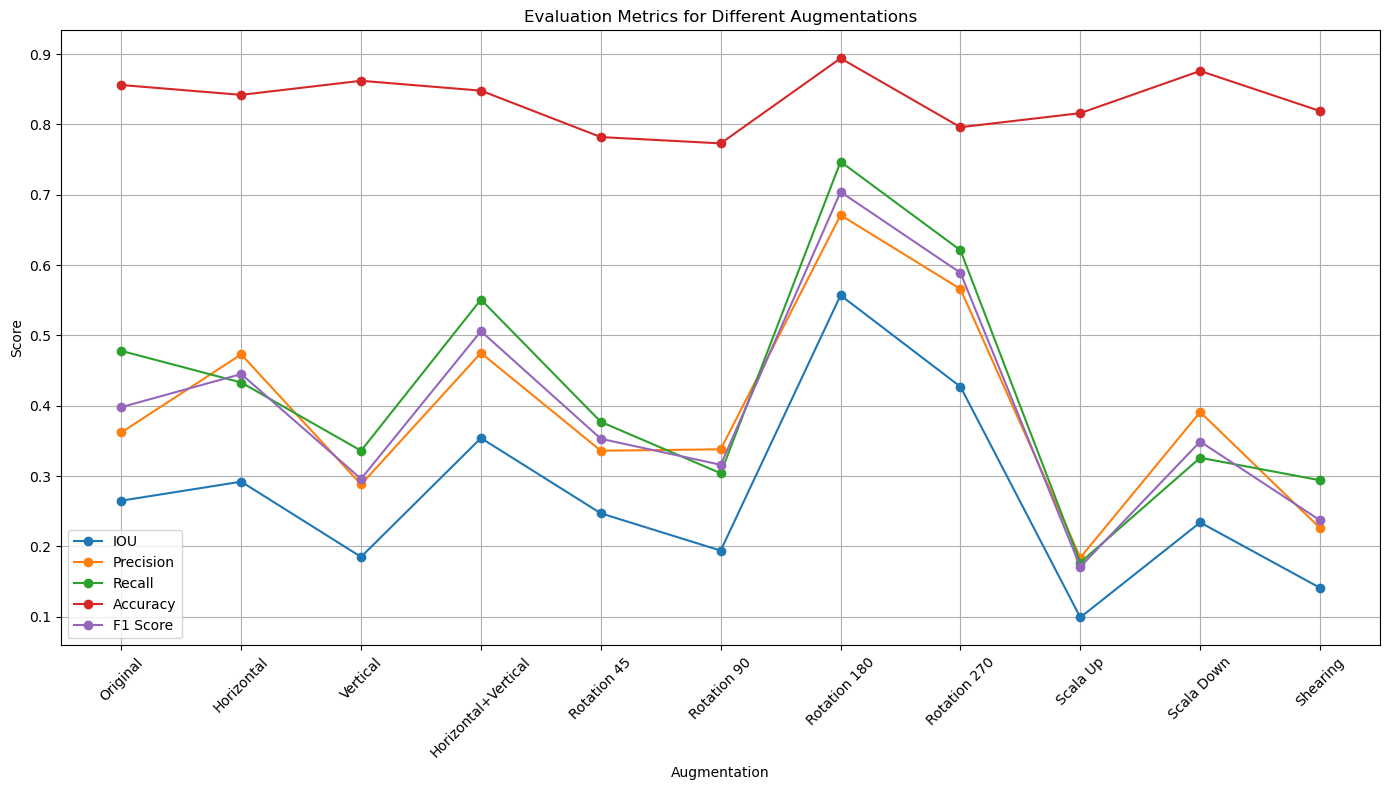

In [22]:
# Data Augmentation dan metrik evaluasi yang sudah ada
data_existing = {
    'Augmentation': ['Original', 'Horizontal', 'Vertical', 'Horizontal+Vertical', 
                     'Rotation 45', 'Rotation 90', 'Rotation 180', 'Rotation 270', 
                     'Scala Up', 'Scala Down', 'Shearing'],
     'IOU': [0.265, 0.292, 0.185, 0.354, 0.247, 0.194, 0.557, 0.427, 0.099, 0.234, 0.141],
    'Precision': [0.362, 0.473, 0.288, 0.475, 0.336, 0.338, 0.671, 0.566, 0.184, 0.391, 0.226],
    'Recall': [0.478, 0.433, 0.336, 0.551, 0.377, 0.304, 0.747, 0.621, 0.177, 0.326, 0.294],
    'Accuracy': [0.856, 0.842, 0.862, 0.848, 0.782, 0.773, 0.894, 0.796, 0.816, 0.876, 0.819],
    'F1 Score': [0.398, 0.445, 0.296, 0.506, 0.353, 0.316, 0.704, 0.589, 0.171, 0.349, 0.237]
}

# Plot IOU
plt.plot(df_ex['Augmentation'], df_ex['IOU'], marker='o', label='IOU')
# Plot Precision
plt.plot(df_ex['Augmentation'], df_ex['Precision'], marker='o', label='Precision')
# Plot Recall
plt.plot(df_ex['Augmentation'], df_ex['Recall'], marker='o', label='Recall')
# Plot Accuracy
plt.plot(df_ex['Augmentation'], df_ex['Accuracy'], marker='o', label='Accuracy')
# Plot F1 Score
plt.plot(df_ex['Augmentation'], df_ex['F1 Score'], marker='o', label='F1 Score')

# Menambahkan label pada sumbu dan judul
plt.xlabel('Augmentation')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Different Augmentations')
plt.xticks(rotation=45)
plt.legend()

# Menampilkan plot
plt.grid(True)
plt.tight_layout()
plt.show()

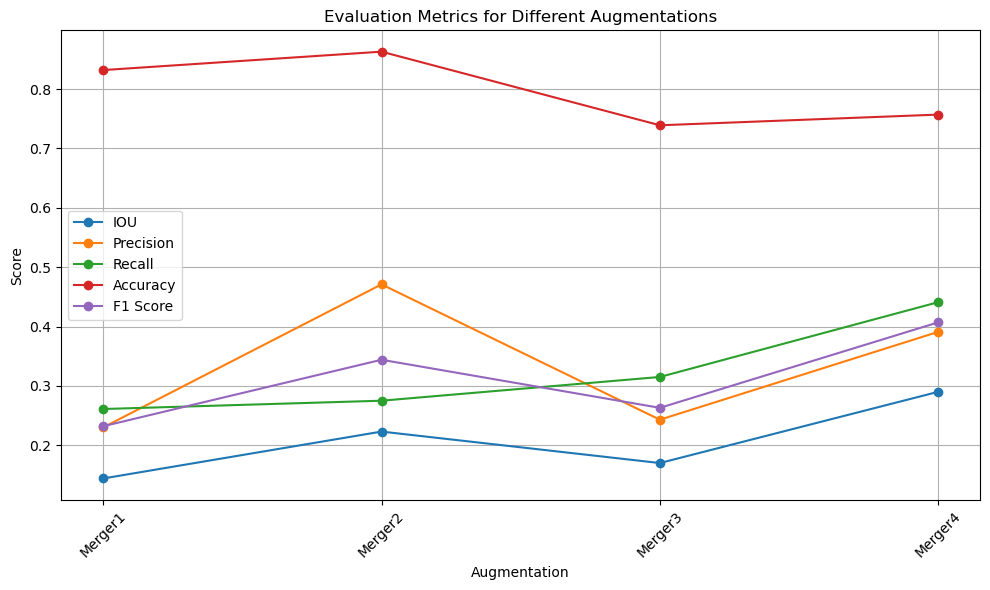

In [10]:
# Data Augmentation dan metrik evaluasi
data = {
   'Augmentation': ['Merger1', 'Merger2',
                     'Merger3', 'Merger4'],
    'IOU': [0.144, 0.223, 0.170, 0.290],
    'Precision': [0.230, 0.471, 0.243, 0.391],
    'Recall': [0.261, 0.275, 0.315, 0.441],
    'Accuracy': [0.832, 0.863, 0.739, 0.757],
    'F1 Score': [0.232, 0.344, 0.263, 0.407]
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Plotting metrik evaluasi untuk setiap Augmentation
plt.figure(figsize=(10, 6))

# Plot IOU
plt.plot(df['Augmentation'], df['IOU'], marker='o', label='IOU')
# Plot Precision
plt.plot(df['Augmentation'], df['Precision'], marker='o', label='Precision')
# Plot Recall
plt.plot(df['Augmentation'], df['Recall'], marker='o', label='Recall')
# Plot Accuracy
plt.plot(df['Augmentation'], df['Accuracy'], marker='o', label='Accuracy')
# Plot F1 Score
plt.plot(df['Augmentation'], df['F1 Score'], marker='o', label='F1 Score')

# Menambahkan label pada sumbu dan judul
plt.xlabel('Augmentation')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Different Augmentations')
plt.xticks(rotation=45)
plt.legend()

# Menampilkan plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Data Augmentation dan metrik evaluasi
data = {
    'Augmentation': ['Original', 'Horizontal', 'Vertical', 'Horizontal+Vertical', 
                     'Rotation 45', 'Rotation 90', 'Rotation 180', 'Rotation 270', 
                     'Scala Up', 'Scala Down', 'Shearing'],
    'IOU': [0.265, 0.292, 0.185, 0.354, 0.247, 0.194, 0.557, 0.427, 0.099, 0.234, 0.141],
    'Precision': [0.362, 0.473, 0.288, 0.475, 0.336, 0.338, 0.671, 0.566, 0.184, 0.391, 0.226],
    'Recall': [0.478, 0.433, 0.336, 0.551, 0.377, 0.304, 0.747, 0.621, 0.177, 0.326, 0.294],
    'Accuracy': [0.856, 0.842, 0.862, 0.848, 0.782, 0.773, 0.894, 0.796, 0.816, 0.876, 0.819],
    'F1 Score': [0.398, 0.445, 0.296, 0.506, 0.353, 0.316, 0.704, 0.589, 0.171, 0.349, 0.237]
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Menghapus kolom 'Augmentation'
df_numeric = df.drop(columns=['Augmentation'])

# Menghitung matriks korelasi
correlation_matrix = df_numeric.corr()

# Menampilkan matriks korelasi
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                IOU  Precision    Recall  Accuracy  F1 Score
IOU        1.000000   0.977318  0.978685  0.376042  0.994621
Precision  0.977318   1.000000  0.938978  0.366137  0.986514
Recall     0.978685   0.938978  1.000000  0.378223  0.981572
Accuracy   0.376042   0.366137  0.378223  1.000000  0.359276
F1 Score   0.994621   0.986514  0.981572  0.359276  1.000000


In [24]:
# Data Augmentation dan metrik evaluasi
data = {
   'Augmentation': ['HVR180', 'HVR180SD',
                     'HVR270', 'HVR270SD'],
    'IOU': [0.144, 0.223, 0.170, 0.290],
    'Precision': [0.230, 0.471, 0.243, 0.391],
    'Recall': [0.261, 0.275, 0.315, 0.441],
    'Accuracy': [0.832, 0.863, 0.739, 0.757],
    'F1 Score': [0.232, 0.344, 0.263, 0.407]
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Menghapus kolom 'Augmentation'
df_numeric = df.drop(columns=['Augmentation'])

# Menghitung matriks korelasi
correlation_matrix = df_numeric.corr()

# Menampilkan matriks korelasi
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                IOU  Precision    Recall  Accuracy  F1 Score
IOU        1.000000   0.743418  0.834358 -0.202431  0.994160
Precision  0.743418   1.000000  0.254614  0.403499  0.811022
Recall     0.834358   0.254614  1.000000 -0.658470  0.771281
Accuracy  -0.202431   0.403499 -0.658470  1.000000 -0.116658
F1 Score   0.994160   0.811022  0.771281 -0.116658  1.000000


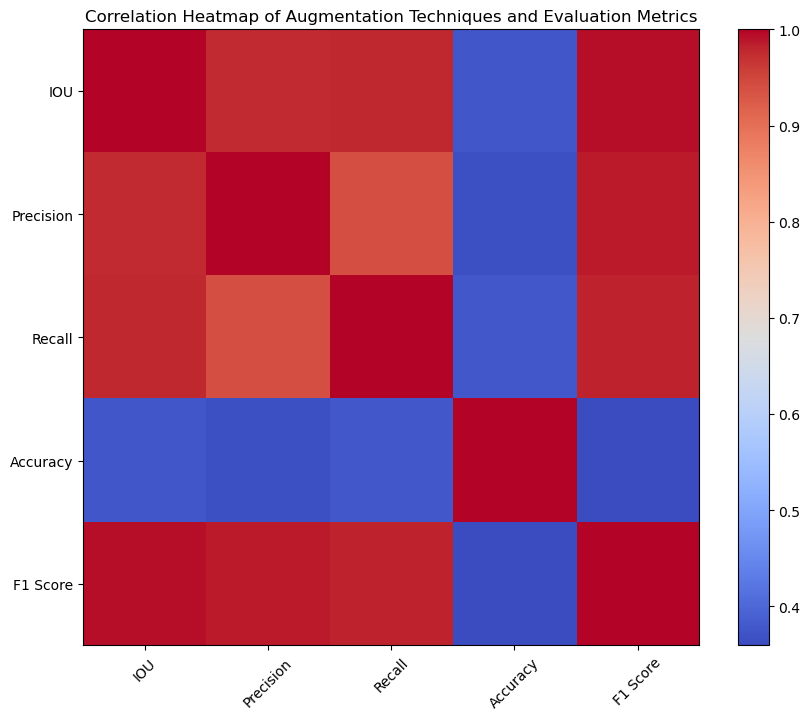

In [26]:
# Data Augmentation dan metrik evaluasi
data = {
    'Augmentation': ['Original', 'Horizontal', 'Vertical', 'Horizontal+Vertical', 
                     'Rotation 45', 'Rotation 90', 'Rotation 180', 'Rotation 270', 
                     'Scala Up', 'Scala Down', 'Shearing'],
    'IOU': [0.265, 0.292, 0.185, 0.354, 0.247, 0.194, 0.557, 0.427, 0.099, 0.234, 0.141],
    'Precision': [0.362, 0.473, 0.288, 0.475, 0.336, 0.338, 0.671, 0.566, 0.184, 0.391, 0.226],
    'Recall': [0.478, 0.433, 0.336, 0.551, 0.377, 0.304, 0.747, 0.621, 0.177, 0.326, 0.294],
    'Accuracy': [0.856, 0.842, 0.862, 0.848, 0.782, 0.773, 0.894, 0.796, 0.816, 0.876, 0.819],
    'F1 Score': [0.398, 0.445, 0.296, 0.506, 0.353, 0.316, 0.704, 0.589, 0.171, 0.349, 0.237]
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Menampilkan korelasi antara kolom 'Augmentation' dan metrik evaluasi
correlation_matrix = df.drop(columns=['Augmentation']).corr()

# Membuat heatmap untuk visualisasi korelasi
plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap of Augmentation Techniques and Evaluation Metrics')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

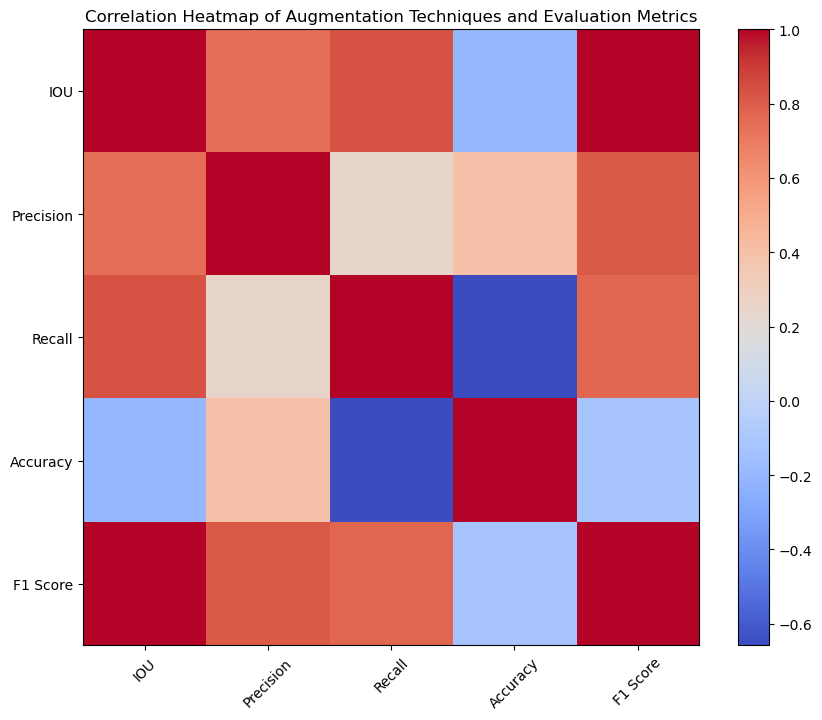

In [30]:
data_new = {
    'Merger': ['Horizontal_Vertical + Rotation180', 
               'Horizontal_Vertical + Rotation180 + ScalaDown',
               'Horizontal_Vertical + Rotation270',
               'Horizontal_Vertical + Rotation270 + ScalaDown'],
    'IOU': [0.144, 0.223, 0.170, 0.290],
    'Precision': [0.230, 0.471, 0.243, 0.391],
    'Recall': [0.261, 0.275, 0.315, 0.441],
    'Accuracy': [0.832, 0.863, 0.739, 0.757],
    'F1 Score': [0.232, 0.344, 0.263, 0.407]
}

# Membuat DataFrame dari data baru
df_new = pd.DataFrame(data_new)

# Menampilkan korelasi antara kolom 'Merger' dan metrik evaluasi
correlation_matrix1 = df_new.drop(columns=['Merger']).corr()

# Membuat heatmap untuk visualisasi korelasi
plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap of Augmentation Techniques and Evaluation Metrics')
plt.imshow(correlation_matrix1, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix1.columns)), correlation_matrix1.columns, rotation=45)
plt.yticks(range(len(correlation_matrix1.columns)), correlation_matrix1.columns)
plt.show()

# =================================================== Hitung Korelasi seluruh data =================